# MOS score prediction from wav2vec2 embeddings

* calculate wav2vec2 embeddings for test and train datasets
* create MOSDataset, containing wav2vec2 embeddings and subjective MOS scores
* define a simple neural network to predict MOS scores from wav2vec2 embeddings
* train the neural network and save the model
* evaluate the model
* repeat the process for different wav2vec2 models? other embeddings? use embeddings from different layers? need another 8 months to finish this notebook

In [1]:
import os
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# wav2vec
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model, Wav2Vec2Config
import librosa

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/home/aleph/tesis/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# wav2vec2 embeddings extraction

In [2]:
def wav2vec_embeddings(path_to_csv, model_name, output_dir):
    """Extracts embeddings from audio files given a specific Wav2Vec2 model.
    Extracts all layers and stacks them together into a tensor. Then saves that tensor as a numpy array.
    Expects csv file with a column named "stimuli" containing paths to audio files."""

    os.makedirs(output_dir, exist_ok=True)

    config = Wav2Vec2Config.from_pretrained(model_name, output_hidden_states=True)
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
    model = Wav2Vec2Model(config)
    
    #load data
    metadata_df = pd.read_csv(path_to_csv)

    # iterate over each path in "stimuli" column
    for _, row in tqdm(metadata_df.iterrows()):
        audio_file = row['stimuli']
        input_audio, sample_rate = librosa.load(audio_file, sr=16000)
        inputs = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
        
        with torch.no_grad():
            outputs= model(**inputs)
        
        all_layer_embeddings = outputs.hidden_states

        # Concatenate hidden states from all layers and take the mean across the sequence
        # Skip the first layer --> output of the CNN layers with an added positional embedding
        embeddings = torch.cat(all_layer_embeddings[, dim=0)
        embeddings = embeddings.mean(dim=1)

        # Save embeddings as numpy array
        embeddings = embeddings.squeeze().detach().numpy()
        file_name = os.path.basename(audio_file).split('.')[0]

        np.save(os.path.join(output_dir, f"{file_name}.npy"), embeddings)

In [9]:
# extract embeddings for dev set
path_to_dev_csv = '/home/aleph/tesis/classifier/dev.csv'
path_to_dev_embeddings = '/home/aleph/tesis/classifier/embeddings/dev'
# wav2vec_embeddings(path_to_dev_csv, path_to_dev_embeddings)

# extract embeddings for test set
path_to_test_csv = '/home/aleph/tesis/classifier/test.csv'
path_to_test_embeddings = '/home/aleph/tesis/classifier/embeddings/test'
# wav2vec_embeddings(path_to_test_csv, path_to_test_embeddings)

# extract embeddings for train set
path_to_train_csv = '/home/aleph/tesis/classifier/train.csv'
path_to_train_embeddings = '/home/aleph/tesis/classifier/embeddings/train'
# wav2vec_embeddings(path_to_train_csv, path_to_train_embeddings)

OSError: facebook/wav2vec2-base-960h does not appear to have a file named config.json. Checkout 'https://huggingface.co/facebook/wav2vec2-base-960h/tree/main' for available files.

## attempt to plot some sort of distribution of the embeddings

In [12]:
# let's explore the embeddings to see distributions of data
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
from numpy import float32

# get the embeddings read from the csv
train_embeddings = pd.read_csv(path_to_save_train_embeddings)
test_embeddings = pd.read_csv(path_to_save_test_embeddings)

# get the embeddings
train_embeddings = train_embeddings['embeddings']
test_embeddings = test_embeddings['embeddings']

# convert the strings to lists
train_embeddings = train_embeddings.apply(lambda x: eval(x))
test_embeddings = test_embeddings.apply(lambda x: eval(x))

# convert the lists to numpy arrays
train_embeddings = np.array(train_embeddings.tolist())
test_embeddings = np.array(test_embeddings.tolist())

# get the shape of the embeddings
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")




Train embeddings shape: (3473, 1, 768)
Test embeddings shape: (863, 1, 768)


In [38]:
import umap.umap_ as umap

#Create a numpy array with the features and project them to 2D using UMAP:
X = np.stack(train_embeddings.squeeze())
print('Projecting to 2D with UMAP')
projector = umap.UMAP()
projected = projector.fit_transform(X)
metadata_df = pd.DataFrame()
metadata_df['X'] = projected[:,0]
metadata_df['Y'] = projected[:,1]

Projecting to 2D with UMAP


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


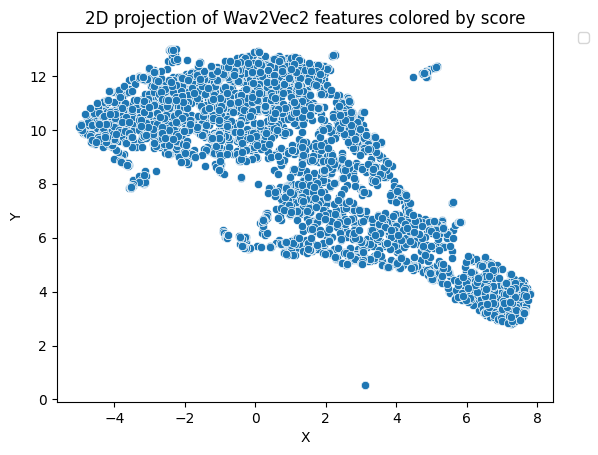

In [40]:
plt.title('2D projection of Wav2Vec2 features colored by score')
sns.scatterplot(data=metadata_df,x='X',y='Y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Projecting to 2D with UMAP


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


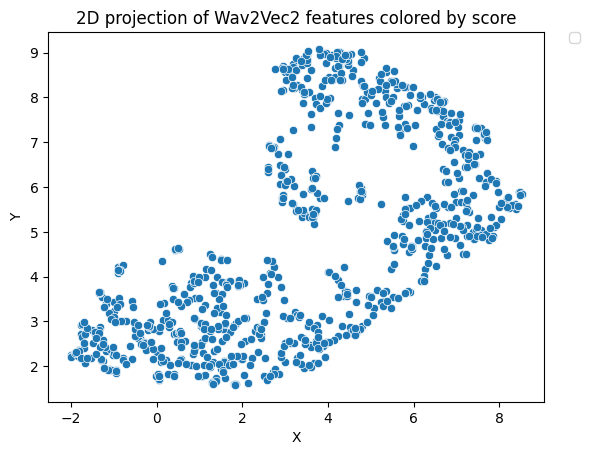

In [41]:
import umap.umap_ as umap

#Create a numpy array with the features and project them to 2D using UMAP:
X = np.stack(test_embeddings.squeeze())
print('Projecting to 2D with UMAP')
projector = umap.UMAP()
projected = projector.fit_transform(X)
metadata_df = pd.DataFrame()
metadata_df['X'] = projected[:,0]
metadata_df['Y'] = projected[:,1]

plt.title('2D projection of Wav2Vec2 features colored by score')
sns.scatterplot(data=metadata_df,x='X',y='Y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# MOSDataset
* Convert the embeddings from string representations into proper tensors.
* Separate the data into features (embeddings) and targets (MOS scores).

In [99]:
# Custom dataset to read embeddings and MOS scores from a CSV
from numpy import array
from numpy import float32

class MOSDataset(Dataset):
    def __init__(self, csv_file, split):
        # Load the CSV file
        self.data = pd.read_csv(csv_file)
        self.split = split  # Store the split (train, val, test)

        
    def __len__(self):
        return len(self.data)  # Total number of samples in the dataset
    
    def __getitem__(self, idx):
        # Get the embeddings and MOS scores for the given index
        file_name = os.path.basename(self.data.iloc[idx]['stimuli'])
        file_folder = os.path.basename(os.path.dirname(self.data.iloc[idx]['stimuli']))

        embeddings_path = f"/home/aleph/tesis/classifier/embeddings/{self.split}/{file_folder}/{file_name.split('.')[0]}.npy"

        # Check if the embeddings file exists
        if not os.path.isfile(embeddings_path):
            raise FileNotFoundError(f"Embeddings file not found at {embeddings_path}")

        embeddings = np.load(embeddings_path)

        mos_score = self.data.iloc[idx]['mos']

        # Convert the numpy array of embeddings to a tensor
        embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)  # Convert to PyTorch tensor

        # drop first layer
        # embeddings_tensor = embeddings_tensor[1:]
                
        # MOS score should be a single value
        mos_tensor = torch.tensor([mos_score], dtype=torch.float32)  # Convert to tensor
        
        return embeddings_tensor, mos_tensor

# Create the training DataLoader
train_csv_path = "/home/aleph/tesis/classifier/train.csv"
train_dataset = MOSDataset(train_csv_path, split='train')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)  # DataLoader with batching and shuffling

# Create the validation DataLoader
val_csv_path = "/home/aleph/tesis/classifier/val.csv"
val_dataset = MOSDataset(val_csv_path, split='val')
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Create the testing DataLoader
test_csv_path = "/home/aleph/tesis/classifier/test.csv"
test_dataset = MOSDataset(test_csv_path, split='test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2) 


In [100]:
# Test getting an item
try:
    embeddings, mos = test_dataset[0]  # Test the first item
    print("Embeddings shape:", embeddings.shape)  # Expected shape
    print("MOS score:", mos.item())  # Expected MOS score
except Exception as e:
    print("Error getting item:", e)

Embeddings shape: torch.Size([13, 768])
MOS score: 1.5


In [101]:
#print length of the datasets
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

Train dataset length: 3136
Validation dataset length: 313
Test dataset length: 307


# Neural network

In [170]:
class WeightedAverage(torch.nn.Module):
    def __init__(self, num_layers=12):
        super().__init__()
        self.weights = torch.nn.Parameter(data=torch.ones((num_layers,)))
       
    def forward(self, x):
        w = torch.nn.functional.softmax(self.weights, dim=0)
        x_weighted = x*w[None,:,None]
        return torch.sum(x_weighted, dim=1)

class DenseMOS(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob, num_layers):
        super(DenseMOS, self).__init__()

        # add a weighted average layer
        self.weighted_average = WeightedAverage(num_layers)
        
        # First dense layer with 128 neurons, ReLU activation, and dropout
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Linear layer for dense transformation
            nn.ReLU(),  # ReLU activation
            nn.Dropout(dropout_prob),  # Dropout with 0.2
        )

        # Second dense layer, same design
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
        )

        # Final dense layer for MOS score prediction
        self.output_layer = nn.Linear(hidden_dim, 1)  # Linear layer to predict MOS

    def forward(self, x):
        # Apply the weighted average to combine 12 layers into 1
        x = self.weighted_average(x)  # Apply WeightedAverage

        # Pass the input through the first dense layer
        x = self.layer1(x)

        # Pass through the second dense layer
        x = self.layer2(x)

        # Pass through the final dense layer to get the MOS score
        x = self.output_layer(x)  # Output layer

        # # Constrain the output to the 1-5 range
        # x = torch.sigmoid(x)  # Constrain between 0 and 1
        # x = 1 + 4 * x  # Scale to 1-5

        return x


# Define the model parameters
input_dim = 768  # Single 768-dimensional input
hidden_dim = 128  # Hidden dimension for dense layers
dropout_prob = 0.6  # Dropout probability
num_layers = 13  # Number of layers in the Wav2Vec2 model

# Training

In [171]:
# Instantiate the DenseMOS model
dense_mos = DenseMOS(input_dim, hidden_dim, dropout_prob, num_layers)
dense_mos.to(device)  # Move the model to the device

DenseMOS(
  (weighted_average): WeightedAverage()
  (layer1): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

## Define a Loss Function and Optimizer


In [172]:
# define loss and optimizer
loss_fn = nn.MSELoss()  # Mean squared error loss
# propose a different possible loss function
# loss_fn = nn.SmoothL1Loss()  # Huber loss

# Assuming you are using an optimizer like Adam
# optimizer = torch.optim.Adam(dense_mos.parameters(), lr=1e-4, weight_decay=1e-5)  # Add L2 regularization
# optimizer = torch.optim.Adam(dense_mos.parameters(), lr=1e-4)

base_params = [p for name, p in dense_mos.named_parameters() if "weights" not in name]
weight_params = [dense_mos.weighted_average.weights]
optimizer = torch.optim.Adam([
    {'params': base_params},
    {'params': weight_params, 'lr': 1e-3}  # Higher learning rate for weights
], lr=1e-5)

## Training Loop

In [173]:
# Number of epochs and batch size
num_epochs = 1000 # Number of training epochs
batch_size = 32  # Batch size for training

# DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Ensure batch size and shuffle
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No shuffle for validation

# Track training and validation loss
train_losses = []
val_losses = []

# For early stopping
best_val_loss = float('inf')  # To track the best validation loss
patience = 25  # Patience for early stopping
no_improvement_count = 0  # Counter for epochs without improvement

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Decay LR every 10 epochs

for epoch in range(num_epochs):
    # Training phase with progress bar
    dense_mos.train()  # Set model to training mode
    train_loss = 0.0  # Initialize the training loss
    
    # Use tqdm for progress tracking
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for inputs, targets in train_loader:
            inputs = inputs.to(device)  # Move inputs to the GPU
            targets = targets.to(device)  # Move targets to the GPU

            optimizer.zero_grad()  # Zero out the gradients
            
            outputs = dense_mos(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)  # Compute the loss
            loss.backward()  # Backpropagation
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(dense_mos.parameters(), 1.0)  # Adjust value if needed
            
            optimizer.step()  # Update the weights
            
            train_loss += loss.item()  # Accumulate the loss
            
            pbar.update(1)  # Update the progress bar

    train_loss /= len(train_loader)  # Average loss over all batches
    train_losses.append(train_loss)  # Save the training loss

    # Validation phase
    dense_mos.eval()  # Set model to evaluation mode
    val_loss = 0.0  # Initialize the validation loss

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)  # Move inputs to the GPU
            targets = targets.to(device)  # Move targets to the GPU

            outputs = dense_mos(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)  # Calculate loss
            val_loss += loss.item()  # Accumulate the validation loss

    val_loss /= len(val_loader)  # Average validation loss over all batches
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    # scheduler.step() # Step the scheduler

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(dense_mos.state_dict(), "best_model.pth")  # Save the best model
        no_improvement_count = 0  # Reset counter
    else:
        no_improvement_count += 1  # Increment counter if no improvement

    # Early stopping check
    if no_improvement_count >= patience:
        print(f"Stopping early after {epoch + 1} epochs due to no improvement in validation loss.")
        break

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the model (optional)
        torch.save(dense_mos.state_dict(), "best_model.pth")

    # Save the model at the end of training
    torch.save(dense_mos.state_dict(), "final_model.pth")

    # print the softmax of the weights of the weighted average layer
    # print(dense_mos.weighted_average.weights)
    # print(torch.nn.functional.softmax(dense_mos.weighted_average.weights, dim=0))
# save train and val losses to csv
losses = pd.DataFrame({'train_loss': train_losses, 'val_loss': val_losses})
losses.to_csv('losses.csv', index=False)

Epoch 1/1000: 100%|██████████| 98/98 [00:01<00:00, 97.98it/s]


Epoch 1/1000, Training Loss: 9.4373, Validation Loss: 3.8162


Epoch 2/1000: 100%|██████████| 98/98 [00:00<00:00, 105.23it/s]


Epoch 2/1000, Training Loss: 8.1958, Validation Loss: 3.7348


Epoch 3/1000: 100%|██████████| 98/98 [00:00<00:00, 103.49it/s]


Epoch 3/1000, Training Loss: 6.7865, Validation Loss: 3.6529


Epoch 4/1000: 100%|██████████| 98/98 [00:00<00:00, 109.07it/s]


Epoch 4/1000, Training Loss: 5.3577, Validation Loss: 3.5703


Epoch 5/1000: 100%|██████████| 98/98 [00:00<00:00, 112.00it/s]


Epoch 5/1000, Training Loss: 3.9863, Validation Loss: 3.4806


Epoch 6/1000: 100%|██████████| 98/98 [00:00<00:00, 115.11it/s]


Epoch 6/1000, Training Loss: 2.9992, Validation Loss: 3.4016


Epoch 7/1000: 100%|██████████| 98/98 [00:00<00:00, 112.53it/s]


Epoch 7/1000, Training Loss: 2.7355, Validation Loss: 3.3500


Epoch 8/1000: 100%|██████████| 98/98 [00:00<00:00, 109.42it/s]


Epoch 8/1000, Training Loss: 2.5493, Validation Loss: 3.3149


Epoch 9/1000: 100%|██████████| 98/98 [00:00<00:00, 111.17it/s]


Epoch 9/1000, Training Loss: 2.5621, Validation Loss: 3.2948


Epoch 10/1000: 100%|██████████| 98/98 [00:00<00:00, 108.81it/s]


Epoch 10/1000, Training Loss: 2.5842, Validation Loss: 3.2692


Epoch 11/1000: 100%|██████████| 98/98 [00:00<00:00, 108.05it/s]


Epoch 11/1000, Training Loss: 2.5591, Validation Loss: 3.2449


Epoch 12/1000: 100%|██████████| 98/98 [00:00<00:00, 111.90it/s]


Epoch 12/1000, Training Loss: 2.5061, Validation Loss: 3.2156


Epoch 13/1000: 100%|██████████| 98/98 [00:00<00:00, 104.30it/s]


Epoch 13/1000, Training Loss: 2.4458, Validation Loss: 3.1889


Epoch 14/1000: 100%|██████████| 98/98 [00:00<00:00, 109.65it/s]


Epoch 14/1000, Training Loss: 2.3676, Validation Loss: 3.1563


Epoch 15/1000: 100%|██████████| 98/98 [00:00<00:00, 111.14it/s]


Epoch 15/1000, Training Loss: 2.2784, Validation Loss: 3.1284


Epoch 16/1000: 100%|██████████| 98/98 [00:00<00:00, 109.96it/s]


Epoch 16/1000, Training Loss: 2.3913, Validation Loss: 3.0976


Epoch 17/1000: 100%|██████████| 98/98 [00:01<00:00, 91.05it/s]


Epoch 17/1000, Training Loss: 2.3403, Validation Loss: 3.0651


Epoch 18/1000: 100%|██████████| 98/98 [00:01<00:00, 95.03it/s]


Epoch 18/1000, Training Loss: 2.3199, Validation Loss: 3.0344


Epoch 19/1000: 100%|██████████| 98/98 [00:00<00:00, 100.20it/s]


Epoch 19/1000, Training Loss: 2.2617, Validation Loss: 3.0055


Epoch 20/1000: 100%|██████████| 98/98 [00:00<00:00, 106.99it/s]


Epoch 20/1000, Training Loss: 2.1870, Validation Loss: 2.9738


Epoch 21/1000: 100%|██████████| 98/98 [00:00<00:00, 110.87it/s]


Epoch 21/1000, Training Loss: 2.1493, Validation Loss: 2.9445


Epoch 22/1000: 100%|██████████| 98/98 [00:00<00:00, 106.77it/s]


Epoch 22/1000, Training Loss: 2.1269, Validation Loss: 2.9211


Epoch 23/1000: 100%|██████████| 98/98 [00:00<00:00, 104.61it/s]


Epoch 23/1000, Training Loss: 2.0865, Validation Loss: 2.8937


Epoch 24/1000: 100%|██████████| 98/98 [00:00<00:00, 101.56it/s]


Epoch 24/1000, Training Loss: 2.1177, Validation Loss: 2.8704


Epoch 25/1000: 100%|██████████| 98/98 [00:01<00:00, 93.59it/s]


Epoch 25/1000, Training Loss: 2.0262, Validation Loss: 2.8460


Epoch 26/1000: 100%|██████████| 98/98 [00:01<00:00, 97.36it/s]


Epoch 26/1000, Training Loss: 2.0973, Validation Loss: 2.8250


Epoch 27/1000: 100%|██████████| 98/98 [00:00<00:00, 101.51it/s]


Epoch 27/1000, Training Loss: 2.0999, Validation Loss: 2.7995


Epoch 28/1000: 100%|██████████| 98/98 [00:01<00:00, 97.47it/s]


Epoch 28/1000, Training Loss: 2.0448, Validation Loss: 2.7731


Epoch 29/1000: 100%|██████████| 98/98 [00:01<00:00, 93.76it/s]


Epoch 29/1000, Training Loss: 1.9959, Validation Loss: 2.7496


Epoch 30/1000: 100%|██████████| 98/98 [00:01<00:00, 92.79it/s]


Epoch 30/1000, Training Loss: 2.0194, Validation Loss: 2.7227


Epoch 31/1000: 100%|██████████| 98/98 [00:00<00:00, 103.27it/s]


Epoch 31/1000, Training Loss: 1.9578, Validation Loss: 2.7024


Epoch 32/1000: 100%|██████████| 98/98 [00:01<00:00, 97.69it/s] 


Epoch 32/1000, Training Loss: 1.9615, Validation Loss: 2.6832


Epoch 33/1000: 100%|██████████| 98/98 [00:00<00:00, 104.77it/s]


Epoch 33/1000, Training Loss: 1.9890, Validation Loss: 2.6667


Epoch 34/1000: 100%|██████████| 98/98 [00:00<00:00, 110.19it/s]


Epoch 34/1000, Training Loss: 1.9542, Validation Loss: 2.6540


Epoch 35/1000: 100%|██████████| 98/98 [00:00<00:00, 98.80it/s] 


Epoch 35/1000, Training Loss: 1.9205, Validation Loss: 2.6298


Epoch 36/1000: 100%|██████████| 98/98 [00:00<00:00, 105.42it/s]


Epoch 36/1000, Training Loss: 1.9050, Validation Loss: 2.6158


Epoch 37/1000: 100%|██████████| 98/98 [00:00<00:00, 101.44it/s]


Epoch 37/1000, Training Loss: 1.8977, Validation Loss: 2.5988


Epoch 38/1000: 100%|██████████| 98/98 [00:00<00:00, 109.09it/s]


Epoch 38/1000, Training Loss: 1.9210, Validation Loss: 2.5866


Epoch 39/1000: 100%|██████████| 98/98 [00:00<00:00, 104.78it/s]


Epoch 39/1000, Training Loss: 1.8896, Validation Loss: 2.5662


Epoch 40/1000: 100%|██████████| 98/98 [00:00<00:00, 102.38it/s]


Epoch 40/1000, Training Loss: 1.9425, Validation Loss: 2.5437


Epoch 41/1000: 100%|██████████| 98/98 [00:00<00:00, 103.55it/s]


Epoch 41/1000, Training Loss: 1.8995, Validation Loss: 2.5304


Epoch 42/1000: 100%|██████████| 98/98 [00:00<00:00, 101.56it/s]


Epoch 42/1000, Training Loss: 1.9010, Validation Loss: 2.5171


Epoch 43/1000: 100%|██████████| 98/98 [00:00<00:00, 104.60it/s]


Epoch 43/1000, Training Loss: 1.8787, Validation Loss: 2.4985


Epoch 44/1000: 100%|██████████| 98/98 [00:00<00:00, 98.85it/s] 


Epoch 44/1000, Training Loss: 1.8509, Validation Loss: 2.4909


Epoch 45/1000: 100%|██████████| 98/98 [00:00<00:00, 102.92it/s]


Epoch 45/1000, Training Loss: 1.8898, Validation Loss: 2.4757


Epoch 46/1000: 100%|██████████| 98/98 [00:00<00:00, 109.70it/s]


Epoch 46/1000, Training Loss: 1.8768, Validation Loss: 2.4618


Epoch 47/1000: 100%|██████████| 98/98 [00:00<00:00, 105.10it/s]


Epoch 47/1000, Training Loss: 1.8994, Validation Loss: 2.4507


Epoch 48/1000: 100%|██████████| 98/98 [00:00<00:00, 105.14it/s]


Epoch 48/1000, Training Loss: 1.8593, Validation Loss: 2.4354


Epoch 49/1000: 100%|██████████| 98/98 [00:00<00:00, 111.36it/s]


Epoch 49/1000, Training Loss: 1.8607, Validation Loss: 2.4255


Epoch 50/1000: 100%|██████████| 98/98 [00:00<00:00, 103.34it/s]


Epoch 50/1000, Training Loss: 1.8447, Validation Loss: 2.4162


Epoch 51/1000: 100%|██████████| 98/98 [00:00<00:00, 109.71it/s]


Epoch 51/1000, Training Loss: 1.8336, Validation Loss: 2.4031


Epoch 52/1000: 100%|██████████| 98/98 [00:00<00:00, 100.92it/s]


Epoch 52/1000, Training Loss: 1.8298, Validation Loss: 2.3951


Epoch 53/1000: 100%|██████████| 98/98 [00:00<00:00, 106.05it/s]


Epoch 53/1000, Training Loss: 1.8593, Validation Loss: 2.3823


Epoch 54/1000: 100%|██████████| 98/98 [00:00<00:00, 110.51it/s]


Epoch 54/1000, Training Loss: 1.8295, Validation Loss: 2.3699


Epoch 55/1000: 100%|██████████| 98/98 [00:00<00:00, 104.66it/s]


Epoch 55/1000, Training Loss: 1.8046, Validation Loss: 2.3605


Epoch 56/1000: 100%|██████████| 98/98 [00:00<00:00, 110.18it/s]


Epoch 56/1000, Training Loss: 1.7154, Validation Loss: 2.3493


Epoch 57/1000: 100%|██████████| 98/98 [00:00<00:00, 110.68it/s]


Epoch 57/1000, Training Loss: 1.8042, Validation Loss: 2.3345


Epoch 58/1000: 100%|██████████| 98/98 [00:00<00:00, 111.25it/s]


Epoch 58/1000, Training Loss: 1.7958, Validation Loss: 2.3308


Epoch 59/1000: 100%|██████████| 98/98 [00:00<00:00, 108.90it/s]


Epoch 59/1000, Training Loss: 1.7913, Validation Loss: 2.3226


Epoch 60/1000: 100%|██████████| 98/98 [00:00<00:00, 106.62it/s]


Epoch 60/1000, Training Loss: 1.7655, Validation Loss: 2.3170


Epoch 61/1000: 100%|██████████| 98/98 [00:00<00:00, 108.86it/s]


Epoch 61/1000, Training Loss: 1.7866, Validation Loss: 2.3038


Epoch 62/1000: 100%|██████████| 98/98 [00:00<00:00, 110.49it/s]


Epoch 62/1000, Training Loss: 1.7545, Validation Loss: 2.2893


Epoch 63/1000: 100%|██████████| 98/98 [00:00<00:00, 109.67it/s]


Epoch 63/1000, Training Loss: 1.8054, Validation Loss: 2.2796


Epoch 64/1000: 100%|██████████| 98/98 [00:00<00:00, 110.71it/s]


Epoch 64/1000, Training Loss: 1.7696, Validation Loss: 2.2694


Epoch 65/1000: 100%|██████████| 98/98 [00:00<00:00, 108.38it/s]


Epoch 65/1000, Training Loss: 1.7728, Validation Loss: 2.2556


Epoch 66/1000: 100%|██████████| 98/98 [00:00<00:00, 108.40it/s]


Epoch 66/1000, Training Loss: 1.7926, Validation Loss: 2.2474


Epoch 67/1000: 100%|██████████| 98/98 [00:00<00:00, 111.87it/s]


Epoch 67/1000, Training Loss: 1.7426, Validation Loss: 2.2424


Epoch 68/1000: 100%|██████████| 98/98 [00:00<00:00, 110.70it/s]


Epoch 68/1000, Training Loss: 1.7362, Validation Loss: 2.2344


Epoch 69/1000: 100%|██████████| 98/98 [00:00<00:00, 110.26it/s]


Epoch 69/1000, Training Loss: 1.7287, Validation Loss: 2.2221


Epoch 70/1000: 100%|██████████| 98/98 [00:00<00:00, 112.60it/s]


Epoch 70/1000, Training Loss: 1.7320, Validation Loss: 2.2090


Epoch 71/1000: 100%|██████████| 98/98 [00:00<00:00, 109.83it/s]


Epoch 71/1000, Training Loss: 1.7264, Validation Loss: 2.1938


Epoch 72/1000: 100%|██████████| 98/98 [00:00<00:00, 108.30it/s]


Epoch 72/1000, Training Loss: 1.7246, Validation Loss: 2.1792


Epoch 73/1000: 100%|██████████| 98/98 [00:00<00:00, 105.88it/s]


Epoch 73/1000, Training Loss: 1.6973, Validation Loss: 2.1670


Epoch 74/1000: 100%|██████████| 98/98 [00:00<00:00, 104.76it/s]


Epoch 74/1000, Training Loss: 1.7171, Validation Loss: 2.1568


Epoch 75/1000: 100%|██████████| 98/98 [00:00<00:00, 104.67it/s]


Epoch 75/1000, Training Loss: 1.7105, Validation Loss: 2.1468


Epoch 76/1000: 100%|██████████| 98/98 [00:00<00:00, 108.95it/s]


Epoch 76/1000, Training Loss: 1.6940, Validation Loss: 2.1374


Epoch 77/1000: 100%|██████████| 98/98 [00:00<00:00, 101.98it/s]


Epoch 77/1000, Training Loss: 1.6730, Validation Loss: 2.1241


Epoch 78/1000: 100%|██████████| 98/98 [00:00<00:00, 103.36it/s]


Epoch 78/1000, Training Loss: 1.6999, Validation Loss: 2.1149


Epoch 79/1000: 100%|██████████| 98/98 [00:01<00:00, 97.79it/s] 


Epoch 79/1000, Training Loss: 1.7329, Validation Loss: 2.1073


Epoch 80/1000: 100%|██████████| 98/98 [00:00<00:00, 107.67it/s]


Epoch 80/1000, Training Loss: 1.6780, Validation Loss: 2.0975


Epoch 81/1000: 100%|██████████| 98/98 [00:00<00:00, 105.38it/s]


Epoch 81/1000, Training Loss: 1.7327, Validation Loss: 2.0935


Epoch 82/1000: 100%|██████████| 98/98 [00:00<00:00, 108.28it/s]


Epoch 82/1000, Training Loss: 1.6479, Validation Loss: 2.0856


Epoch 83/1000: 100%|██████████| 98/98 [00:00<00:00, 99.59it/s] 


Epoch 83/1000, Training Loss: 1.6330, Validation Loss: 2.0749


Epoch 84/1000: 100%|██████████| 98/98 [00:00<00:00, 105.23it/s]


Epoch 84/1000, Training Loss: 1.7081, Validation Loss: 2.0666


Epoch 85/1000: 100%|██████████| 98/98 [00:00<00:00, 110.49it/s]


Epoch 85/1000, Training Loss: 1.6816, Validation Loss: 2.0587


Epoch 86/1000: 100%|██████████| 98/98 [00:00<00:00, 107.47it/s]


Epoch 86/1000, Training Loss: 1.6654, Validation Loss: 2.0534


Epoch 87/1000: 100%|██████████| 98/98 [00:00<00:00, 104.42it/s]


Epoch 87/1000, Training Loss: 1.6294, Validation Loss: 2.0448


Epoch 88/1000: 100%|██████████| 98/98 [00:00<00:00, 111.70it/s]


Epoch 88/1000, Training Loss: 1.6574, Validation Loss: 2.0337


Epoch 89/1000: 100%|██████████| 98/98 [00:00<00:00, 107.88it/s]


Epoch 89/1000, Training Loss: 1.7155, Validation Loss: 2.0231


Epoch 90/1000: 100%|██████████| 98/98 [00:00<00:00, 109.28it/s]


Epoch 90/1000, Training Loss: 1.6518, Validation Loss: 2.0069


Epoch 91/1000: 100%|██████████| 98/98 [00:00<00:00, 102.43it/s]


Epoch 91/1000, Training Loss: 1.6687, Validation Loss: 1.9995


Epoch 92/1000: 100%|██████████| 98/98 [00:01<00:00, 90.09it/s]


Epoch 92/1000, Training Loss: 1.6530, Validation Loss: 1.9906


Epoch 93/1000: 100%|██████████| 98/98 [00:01<00:00, 86.53it/s]


Epoch 93/1000, Training Loss: 1.6622, Validation Loss: 1.9807


Epoch 94/1000: 100%|██████████| 98/98 [00:01<00:00, 97.37it/s] 


Epoch 94/1000, Training Loss: 1.6091, Validation Loss: 1.9733


Epoch 95/1000: 100%|██████████| 98/98 [00:01<00:00, 96.85it/s] 


Epoch 95/1000, Training Loss: 1.6864, Validation Loss: 1.9652


Epoch 96/1000: 100%|██████████| 98/98 [00:00<00:00, 100.09it/s]


Epoch 96/1000, Training Loss: 1.6120, Validation Loss: 1.9546


Epoch 97/1000: 100%|██████████| 98/98 [00:00<00:00, 102.26it/s]


Epoch 97/1000, Training Loss: 1.6629, Validation Loss: 1.9423


Epoch 98/1000: 100%|██████████| 98/98 [00:01<00:00, 77.01it/s]


Epoch 98/1000, Training Loss: 1.6116, Validation Loss: 1.9301


Epoch 99/1000: 100%|██████████| 98/98 [00:00<00:00, 104.30it/s]


Epoch 99/1000, Training Loss: 1.6606, Validation Loss: 1.9202


Epoch 100/1000: 100%|██████████| 98/98 [00:00<00:00, 109.47it/s]


Epoch 100/1000, Training Loss: 1.6793, Validation Loss: 1.9169


Epoch 101/1000: 100%|██████████| 98/98 [00:00<00:00, 99.16it/s] 


Epoch 101/1000, Training Loss: 1.6428, Validation Loss: 1.9023


Epoch 102/1000: 100%|██████████| 98/98 [00:00<00:00, 100.65it/s]


Epoch 102/1000, Training Loss: 1.6233, Validation Loss: 1.8968


Epoch 103/1000: 100%|██████████| 98/98 [00:00<00:00, 100.10it/s]


Epoch 103/1000, Training Loss: 1.6037, Validation Loss: 1.8898


Epoch 104/1000: 100%|██████████| 98/98 [00:00<00:00, 109.99it/s]


Epoch 104/1000, Training Loss: 1.6157, Validation Loss: 1.8767


Epoch 105/1000: 100%|██████████| 98/98 [00:00<00:00, 105.82it/s]


Epoch 105/1000, Training Loss: 1.6063, Validation Loss: 1.8624


Epoch 106/1000: 100%|██████████| 98/98 [00:00<00:00, 108.32it/s]


Epoch 106/1000, Training Loss: 1.6603, Validation Loss: 1.8588


Epoch 107/1000: 100%|██████████| 98/98 [00:00<00:00, 109.62it/s]


Epoch 107/1000, Training Loss: 1.6136, Validation Loss: 1.8522


Epoch 108/1000: 100%|██████████| 98/98 [00:00<00:00, 103.19it/s]


Epoch 108/1000, Training Loss: 1.5778, Validation Loss: 1.8437


Epoch 109/1000: 100%|██████████| 98/98 [00:00<00:00, 107.55it/s]


Epoch 109/1000, Training Loss: 1.5948, Validation Loss: 1.8347


Epoch 110/1000: 100%|██████████| 98/98 [00:00<00:00, 101.10it/s]


Epoch 110/1000, Training Loss: 1.5782, Validation Loss: 1.8258


Epoch 111/1000: 100%|██████████| 98/98 [00:01<00:00, 95.45it/s]


Epoch 111/1000, Training Loss: 1.6070, Validation Loss: 1.8168


Epoch 112/1000: 100%|██████████| 98/98 [00:00<00:00, 100.23it/s]


Epoch 112/1000, Training Loss: 1.5870, Validation Loss: 1.8045


Epoch 113/1000: 100%|██████████| 98/98 [00:01<00:00, 96.68it/s] 


Epoch 113/1000, Training Loss: 1.6132, Validation Loss: 1.8010


Epoch 114/1000: 100%|██████████| 98/98 [00:00<00:00, 108.04it/s]


Epoch 114/1000, Training Loss: 1.6295, Validation Loss: 1.7924


Epoch 115/1000: 100%|██████████| 98/98 [00:00<00:00, 102.94it/s]


Epoch 115/1000, Training Loss: 1.5916, Validation Loss: 1.7833


Epoch 116/1000: 100%|██████████| 98/98 [00:00<00:00, 112.44it/s]


Epoch 116/1000, Training Loss: 1.5966, Validation Loss: 1.7766


Epoch 117/1000: 100%|██████████| 98/98 [00:00<00:00, 107.36it/s]


Epoch 117/1000, Training Loss: 1.5865, Validation Loss: 1.7694


Epoch 118/1000: 100%|██████████| 98/98 [00:00<00:00, 102.88it/s]


Epoch 118/1000, Training Loss: 1.6069, Validation Loss: 1.7563


Epoch 119/1000: 100%|██████████| 98/98 [00:00<00:00, 101.15it/s]


Epoch 119/1000, Training Loss: 1.5966, Validation Loss: 1.7462


Epoch 120/1000: 100%|██████████| 98/98 [00:00<00:00, 106.29it/s]


Epoch 120/1000, Training Loss: 1.5800, Validation Loss: 1.7379


Epoch 121/1000: 100%|██████████| 98/98 [00:00<00:00, 99.25it/s] 


Epoch 121/1000, Training Loss: 1.5971, Validation Loss: 1.7342


Epoch 122/1000: 100%|██████████| 98/98 [00:01<00:00, 95.96it/s]


Epoch 122/1000, Training Loss: 1.5838, Validation Loss: 1.7272


Epoch 123/1000: 100%|██████████| 98/98 [00:00<00:00, 103.55it/s]


Epoch 123/1000, Training Loss: 1.5807, Validation Loss: 1.7215


Epoch 124/1000: 100%|██████████| 98/98 [00:00<00:00, 106.25it/s]


Epoch 124/1000, Training Loss: 1.5204, Validation Loss: 1.7079


Epoch 125/1000: 100%|██████████| 98/98 [00:00<00:00, 102.73it/s]


Epoch 125/1000, Training Loss: 1.5571, Validation Loss: 1.6982


Epoch 126/1000: 100%|██████████| 98/98 [00:00<00:00, 107.28it/s]


Epoch 126/1000, Training Loss: 1.5509, Validation Loss: 1.6936


Epoch 127/1000: 100%|██████████| 98/98 [00:00<00:00, 109.40it/s]


Epoch 127/1000, Training Loss: 1.5776, Validation Loss: 1.6830


Epoch 128/1000: 100%|██████████| 98/98 [00:00<00:00, 106.94it/s]


Epoch 128/1000, Training Loss: 1.5817, Validation Loss: 1.6772


Epoch 129/1000: 100%|██████████| 98/98 [00:00<00:00, 109.12it/s]


Epoch 129/1000, Training Loss: 1.5660, Validation Loss: 1.6662


Epoch 130/1000: 100%|██████████| 98/98 [00:00<00:00, 107.50it/s]


Epoch 130/1000, Training Loss: 1.5773, Validation Loss: 1.6597


Epoch 131/1000: 100%|██████████| 98/98 [00:00<00:00, 109.26it/s]


Epoch 131/1000, Training Loss: 1.5555, Validation Loss: 1.6444


Epoch 132/1000: 100%|██████████| 98/98 [00:00<00:00, 109.48it/s]


Epoch 132/1000, Training Loss: 1.5962, Validation Loss: 1.6372


Epoch 133/1000: 100%|██████████| 98/98 [00:00<00:00, 110.81it/s]


Epoch 133/1000, Training Loss: 1.6231, Validation Loss: 1.6292


Epoch 134/1000: 100%|██████████| 98/98 [00:00<00:00, 111.38it/s]


Epoch 134/1000, Training Loss: 1.5160, Validation Loss: 1.6203


Epoch 135/1000: 100%|██████████| 98/98 [00:00<00:00, 111.35it/s]


Epoch 135/1000, Training Loss: 1.5111, Validation Loss: 1.6120


Epoch 136/1000: 100%|██████████| 98/98 [00:00<00:00, 110.01it/s]


Epoch 136/1000, Training Loss: 1.6010, Validation Loss: 1.6104


Epoch 137/1000: 100%|██████████| 98/98 [00:00<00:00, 98.17it/s] 


Epoch 137/1000, Training Loss: 1.5403, Validation Loss: 1.6059


Epoch 138/1000: 100%|██████████| 98/98 [00:01<00:00, 93.95it/s] 


Epoch 138/1000, Training Loss: 1.5627, Validation Loss: 1.5983


Epoch 139/1000: 100%|██████████| 98/98 [00:00<00:00, 102.77it/s]


Epoch 139/1000, Training Loss: 1.5062, Validation Loss: 1.5876


Epoch 140/1000: 100%|██████████| 98/98 [00:00<00:00, 99.52it/s] 


Epoch 140/1000, Training Loss: 1.5581, Validation Loss: 1.5846


Epoch 141/1000: 100%|██████████| 98/98 [00:00<00:00, 98.55it/s] 


Epoch 141/1000, Training Loss: 1.5722, Validation Loss: 1.5830


Epoch 142/1000: 100%|██████████| 98/98 [00:00<00:00, 107.91it/s]


Epoch 142/1000, Training Loss: 1.5993, Validation Loss: 1.5692


Epoch 143/1000: 100%|██████████| 98/98 [00:00<00:00, 111.31it/s]


Epoch 143/1000, Training Loss: 1.5226, Validation Loss: 1.5579


Epoch 144/1000: 100%|██████████| 98/98 [00:00<00:00, 110.77it/s]


Epoch 144/1000, Training Loss: 1.5427, Validation Loss: 1.5485


Epoch 145/1000: 100%|██████████| 98/98 [00:00<00:00, 105.72it/s]


Epoch 145/1000, Training Loss: 1.5941, Validation Loss: 1.5364


Epoch 146/1000: 100%|██████████| 98/98 [00:00<00:00, 103.16it/s]


Epoch 146/1000, Training Loss: 1.5263, Validation Loss: 1.5290


Epoch 147/1000: 100%|██████████| 98/98 [00:00<00:00, 107.77it/s]


Epoch 147/1000, Training Loss: 1.5614, Validation Loss: 1.5209


Epoch 148/1000: 100%|██████████| 98/98 [00:00<00:00, 102.13it/s]


Epoch 148/1000, Training Loss: 1.4567, Validation Loss: 1.5126


Epoch 149/1000: 100%|██████████| 98/98 [00:00<00:00, 108.16it/s]


Epoch 149/1000, Training Loss: 1.4812, Validation Loss: 1.5039


Epoch 150/1000: 100%|██████████| 98/98 [00:00<00:00, 104.54it/s]


Epoch 150/1000, Training Loss: 1.4938, Validation Loss: 1.4957


Epoch 151/1000: 100%|██████████| 98/98 [00:00<00:00, 106.22it/s]


Epoch 151/1000, Training Loss: 1.5138, Validation Loss: 1.4896


Epoch 152/1000: 100%|██████████| 98/98 [00:00<00:00, 106.41it/s]


Epoch 152/1000, Training Loss: 1.5667, Validation Loss: 1.4798


Epoch 153/1000: 100%|██████████| 98/98 [00:00<00:00, 104.03it/s]


Epoch 153/1000, Training Loss: 1.5404, Validation Loss: 1.4691


Epoch 154/1000: 100%|██████████| 98/98 [00:00<00:00, 114.16it/s]


Epoch 154/1000, Training Loss: 1.4727, Validation Loss: 1.4640


Epoch 155/1000: 100%|██████████| 98/98 [00:00<00:00, 107.14it/s]


Epoch 155/1000, Training Loss: 1.5248, Validation Loss: 1.4556


Epoch 156/1000: 100%|██████████| 98/98 [00:01<00:00, 96.85it/s] 


Epoch 156/1000, Training Loss: 1.6113, Validation Loss: 1.4486


Epoch 157/1000: 100%|██████████| 98/98 [00:00<00:00, 108.86it/s]


Epoch 157/1000, Training Loss: 1.4918, Validation Loss: 1.4481


Epoch 158/1000: 100%|██████████| 98/98 [00:00<00:00, 102.92it/s]


Epoch 158/1000, Training Loss: 1.5168, Validation Loss: 1.4384


Epoch 159/1000: 100%|██████████| 98/98 [00:00<00:00, 113.58it/s]


Epoch 159/1000, Training Loss: 1.5183, Validation Loss: 1.4329


Epoch 160/1000: 100%|██████████| 98/98 [00:00<00:00, 113.69it/s]


Epoch 160/1000, Training Loss: 1.4994, Validation Loss: 1.4289


Epoch 161/1000: 100%|██████████| 98/98 [00:00<00:00, 108.93it/s]


Epoch 161/1000, Training Loss: 1.5386, Validation Loss: 1.4194


Epoch 162/1000: 100%|██████████| 98/98 [00:00<00:00, 105.45it/s]


Epoch 162/1000, Training Loss: 1.5101, Validation Loss: 1.4138


Epoch 163/1000: 100%|██████████| 98/98 [00:00<00:00, 108.20it/s]


Epoch 163/1000, Training Loss: 1.5253, Validation Loss: 1.4093


Epoch 164/1000: 100%|██████████| 98/98 [00:00<00:00, 102.81it/s]


Epoch 164/1000, Training Loss: 1.5291, Validation Loss: 1.4022


Epoch 165/1000: 100%|██████████| 98/98 [00:01<00:00, 97.12it/s]


Epoch 165/1000, Training Loss: 1.5027, Validation Loss: 1.3978


Epoch 166/1000: 100%|██████████| 98/98 [00:00<00:00, 110.03it/s]


Epoch 166/1000, Training Loss: 1.4951, Validation Loss: 1.3897


Epoch 167/1000: 100%|██████████| 98/98 [00:00<00:00, 105.92it/s]


Epoch 167/1000, Training Loss: 1.5258, Validation Loss: 1.3842


Epoch 168/1000: 100%|██████████| 98/98 [00:00<00:00, 106.83it/s]


Epoch 168/1000, Training Loss: 1.4879, Validation Loss: 1.3721


Epoch 169/1000: 100%|██████████| 98/98 [00:00<00:00, 105.28it/s]


Epoch 169/1000, Training Loss: 1.4905, Validation Loss: 1.3664


Epoch 170/1000: 100%|██████████| 98/98 [00:00<00:00, 99.48it/s] 


Epoch 170/1000, Training Loss: 1.5057, Validation Loss: 1.3588


Epoch 171/1000: 100%|██████████| 98/98 [00:00<00:00, 101.53it/s]


Epoch 171/1000, Training Loss: 1.4990, Validation Loss: 1.3446


Epoch 172/1000: 100%|██████████| 98/98 [00:00<00:00, 102.14it/s]


Epoch 172/1000, Training Loss: 1.4809, Validation Loss: 1.3395


Epoch 173/1000: 100%|██████████| 98/98 [00:00<00:00, 105.88it/s]


Epoch 173/1000, Training Loss: 1.5465, Validation Loss: 1.3307


Epoch 174/1000: 100%|██████████| 98/98 [00:00<00:00, 107.56it/s]


Epoch 174/1000, Training Loss: 1.5171, Validation Loss: 1.3234


Epoch 175/1000: 100%|██████████| 98/98 [00:00<00:00, 101.62it/s]


Epoch 175/1000, Training Loss: 1.5157, Validation Loss: 1.3137


Epoch 176/1000: 100%|██████████| 98/98 [00:00<00:00, 99.29it/s] 


Epoch 176/1000, Training Loss: 1.4597, Validation Loss: 1.3039


Epoch 177/1000: 100%|██████████| 98/98 [00:00<00:00, 102.98it/s]


Epoch 177/1000, Training Loss: 1.4862, Validation Loss: 1.3010


Epoch 178/1000: 100%|██████████| 98/98 [00:00<00:00, 106.07it/s]


Epoch 178/1000, Training Loss: 1.4546, Validation Loss: 1.2967


Epoch 179/1000: 100%|██████████| 98/98 [00:00<00:00, 106.51it/s]


Epoch 179/1000, Training Loss: 1.5246, Validation Loss: 1.2894


Epoch 180/1000: 100%|██████████| 98/98 [00:00<00:00, 108.28it/s]


Epoch 180/1000, Training Loss: 1.4806, Validation Loss: 1.2787


Epoch 181/1000: 100%|██████████| 98/98 [00:00<00:00, 106.60it/s]


Epoch 181/1000, Training Loss: 1.5094, Validation Loss: 1.2723


Epoch 182/1000: 100%|██████████| 98/98 [00:00<00:00, 101.81it/s]


Epoch 182/1000, Training Loss: 1.4718, Validation Loss: 1.2630


Epoch 183/1000: 100%|██████████| 98/98 [00:00<00:00, 106.33it/s]


Epoch 183/1000, Training Loss: 1.4180, Validation Loss: 1.2552


Epoch 184/1000: 100%|██████████| 98/98 [00:00<00:00, 112.81it/s]


Epoch 184/1000, Training Loss: 1.4737, Validation Loss: 1.2445


Epoch 185/1000: 100%|██████████| 98/98 [00:00<00:00, 113.04it/s]


Epoch 185/1000, Training Loss: 1.4633, Validation Loss: 1.2384


Epoch 186/1000: 100%|██████████| 98/98 [00:00<00:00, 105.25it/s]


Epoch 186/1000, Training Loss: 1.4832, Validation Loss: 1.2305


Epoch 187/1000: 100%|██████████| 98/98 [00:00<00:00, 101.38it/s]


Epoch 187/1000, Training Loss: 1.4798, Validation Loss: 1.2240


Epoch 188/1000: 100%|██████████| 98/98 [00:00<00:00, 103.16it/s]


Epoch 188/1000, Training Loss: 1.4837, Validation Loss: 1.2168


Epoch 189/1000: 100%|██████████| 98/98 [00:01<00:00, 92.57it/s]


Epoch 189/1000, Training Loss: 1.4834, Validation Loss: 1.2095


Epoch 190/1000: 100%|██████████| 98/98 [00:00<00:00, 99.72it/s] 


Epoch 190/1000, Training Loss: 1.4939, Validation Loss: 1.2054


Epoch 191/1000: 100%|██████████| 98/98 [00:00<00:00, 100.39it/s]


Epoch 191/1000, Training Loss: 1.5019, Validation Loss: 1.1991


Epoch 192/1000: 100%|██████████| 98/98 [00:00<00:00, 105.37it/s]


Epoch 192/1000, Training Loss: 1.4329, Validation Loss: 1.1967


Epoch 193/1000: 100%|██████████| 98/98 [00:00<00:00, 107.15it/s]


Epoch 193/1000, Training Loss: 1.4414, Validation Loss: 1.1872


Epoch 194/1000: 100%|██████████| 98/98 [00:00<00:00, 98.86it/s] 


Epoch 194/1000, Training Loss: 1.4600, Validation Loss: 1.1795


Epoch 195/1000: 100%|██████████| 98/98 [00:01<00:00, 94.38it/s]


Epoch 195/1000, Training Loss: 1.4853, Validation Loss: 1.1735


Epoch 196/1000: 100%|██████████| 98/98 [00:01<00:00, 96.44it/s] 


Epoch 196/1000, Training Loss: 1.4493, Validation Loss: 1.1735


Epoch 197/1000: 100%|██████████| 98/98 [00:00<00:00, 105.97it/s]


Epoch 197/1000, Training Loss: 1.4760, Validation Loss: 1.1701


Epoch 198/1000: 100%|██████████| 98/98 [00:00<00:00, 106.17it/s]


Epoch 198/1000, Training Loss: 1.4746, Validation Loss: 1.1641


Epoch 199/1000: 100%|██████████| 98/98 [00:00<00:00, 108.29it/s]


Epoch 199/1000, Training Loss: 1.4348, Validation Loss: 1.1569


Epoch 200/1000: 100%|██████████| 98/98 [00:00<00:00, 108.01it/s]


Epoch 200/1000, Training Loss: 1.4533, Validation Loss: 1.1531


Epoch 201/1000: 100%|██████████| 98/98 [00:00<00:00, 108.62it/s]


Epoch 201/1000, Training Loss: 1.4373, Validation Loss: 1.1492


Epoch 202/1000: 100%|██████████| 98/98 [00:00<00:00, 107.03it/s]


Epoch 202/1000, Training Loss: 1.4765, Validation Loss: 1.1389


Epoch 203/1000: 100%|██████████| 98/98 [00:00<00:00, 107.56it/s]


Epoch 203/1000, Training Loss: 1.4459, Validation Loss: 1.1361


Epoch 204/1000: 100%|██████████| 98/98 [00:00<00:00, 103.99it/s]


Epoch 204/1000, Training Loss: 1.4675, Validation Loss: 1.1314


Epoch 205/1000: 100%|██████████| 98/98 [00:00<00:00, 107.65it/s]


Epoch 205/1000, Training Loss: 1.4384, Validation Loss: 1.1184


Epoch 206/1000: 100%|██████████| 98/98 [00:00<00:00, 105.28it/s]


Epoch 206/1000, Training Loss: 1.4717, Validation Loss: 1.1106


Epoch 207/1000: 100%|██████████| 98/98 [00:00<00:00, 107.49it/s]


Epoch 207/1000, Training Loss: 1.4664, Validation Loss: 1.1079


Epoch 208/1000: 100%|██████████| 98/98 [00:00<00:00, 99.41it/s] 


Epoch 208/1000, Training Loss: 1.4826, Validation Loss: 1.1035


Epoch 209/1000: 100%|██████████| 98/98 [00:00<00:00, 106.11it/s]


Epoch 209/1000, Training Loss: 1.4519, Validation Loss: 1.0975


Epoch 210/1000: 100%|██████████| 98/98 [00:00<00:00, 107.07it/s]


Epoch 210/1000, Training Loss: 1.4917, Validation Loss: 1.0902


Epoch 211/1000: 100%|██████████| 98/98 [00:00<00:00, 104.72it/s]


Epoch 211/1000, Training Loss: 1.4933, Validation Loss: 1.0861


Epoch 212/1000: 100%|██████████| 98/98 [00:01<00:00, 95.39it/s]


Epoch 212/1000, Training Loss: 1.4835, Validation Loss: 1.0830


Epoch 213/1000: 100%|██████████| 98/98 [00:00<00:00, 102.51it/s]


Epoch 213/1000, Training Loss: 1.4313, Validation Loss: 1.0784


Epoch 214/1000: 100%|██████████| 98/98 [00:00<00:00, 107.40it/s]


Epoch 214/1000, Training Loss: 1.4639, Validation Loss: 1.0661


Epoch 215/1000: 100%|██████████| 98/98 [00:00<00:00, 106.65it/s]


Epoch 215/1000, Training Loss: 1.4240, Validation Loss: 1.0600


Epoch 216/1000: 100%|██████████| 98/98 [00:00<00:00, 106.86it/s]


Epoch 216/1000, Training Loss: 1.4289, Validation Loss: 1.0532


Epoch 217/1000: 100%|██████████| 98/98 [00:00<00:00, 104.71it/s]


Epoch 217/1000, Training Loss: 1.4692, Validation Loss: 1.0515


Epoch 218/1000: 100%|██████████| 98/98 [00:00<00:00, 107.43it/s]


Epoch 218/1000, Training Loss: 1.4471, Validation Loss: 1.0466


Epoch 219/1000: 100%|██████████| 98/98 [00:00<00:00, 108.16it/s]


Epoch 219/1000, Training Loss: 1.4722, Validation Loss: 1.0409


Epoch 220/1000: 100%|██████████| 98/98 [00:00<00:00, 106.65it/s]


Epoch 220/1000, Training Loss: 1.4584, Validation Loss: 1.0377


Epoch 221/1000: 100%|██████████| 98/98 [00:00<00:00, 108.05it/s]


Epoch 221/1000, Training Loss: 1.4341, Validation Loss: 1.0312


Epoch 222/1000: 100%|██████████| 98/98 [00:00<00:00, 110.55it/s]


Epoch 222/1000, Training Loss: 1.4265, Validation Loss: 1.0280


Epoch 223/1000: 100%|██████████| 98/98 [00:00<00:00, 111.74it/s]


Epoch 223/1000, Training Loss: 1.4756, Validation Loss: 1.0242


Epoch 224/1000: 100%|██████████| 98/98 [00:00<00:00, 106.69it/s]


Epoch 224/1000, Training Loss: 1.4698, Validation Loss: 1.0168


Epoch 225/1000: 100%|██████████| 98/98 [00:00<00:00, 108.65it/s]


Epoch 225/1000, Training Loss: 1.4066, Validation Loss: 1.0120


Epoch 226/1000: 100%|██████████| 98/98 [00:00<00:00, 107.55it/s]


Epoch 226/1000, Training Loss: 1.4276, Validation Loss: 1.0064


Epoch 227/1000: 100%|██████████| 98/98 [00:00<00:00, 105.54it/s]


Epoch 227/1000, Training Loss: 1.4434, Validation Loss: 1.0042


Epoch 228/1000: 100%|██████████| 98/98 [00:00<00:00, 108.53it/s]


Epoch 228/1000, Training Loss: 1.4232, Validation Loss: 0.9979


Epoch 229/1000: 100%|██████████| 98/98 [00:00<00:00, 106.43it/s]


Epoch 229/1000, Training Loss: 1.4658, Validation Loss: 0.9927


Epoch 230/1000: 100%|██████████| 98/98 [00:00<00:00, 109.12it/s]


Epoch 230/1000, Training Loss: 1.4764, Validation Loss: 0.9874


Epoch 231/1000: 100%|██████████| 98/98 [00:00<00:00, 107.68it/s]


Epoch 231/1000, Training Loss: 1.4570, Validation Loss: 0.9849


Epoch 232/1000: 100%|██████████| 98/98 [00:00<00:00, 110.31it/s]


Epoch 232/1000, Training Loss: 1.3676, Validation Loss: 0.9800


Epoch 233/1000: 100%|██████████| 98/98 [00:00<00:00, 105.21it/s]


Epoch 233/1000, Training Loss: 1.4531, Validation Loss: 0.9753


Epoch 234/1000: 100%|██████████| 98/98 [00:00<00:00, 107.35it/s]


Epoch 234/1000, Training Loss: 1.4503, Validation Loss: 0.9664


Epoch 235/1000: 100%|██████████| 98/98 [00:00<00:00, 109.47it/s]


Epoch 235/1000, Training Loss: 1.4430, Validation Loss: 0.9658


Epoch 236/1000: 100%|██████████| 98/98 [00:00<00:00, 108.48it/s]


Epoch 236/1000, Training Loss: 1.4237, Validation Loss: 0.9607


Epoch 237/1000: 100%|██████████| 98/98 [00:00<00:00, 110.41it/s]


Epoch 237/1000, Training Loss: 1.4065, Validation Loss: 0.9544


Epoch 238/1000: 100%|██████████| 98/98 [00:00<00:00, 110.16it/s]


Epoch 238/1000, Training Loss: 1.3987, Validation Loss: 0.9511


Epoch 239/1000: 100%|██████████| 98/98 [00:00<00:00, 106.39it/s]


Epoch 239/1000, Training Loss: 1.4287, Validation Loss: 0.9471


Epoch 240/1000: 100%|██████████| 98/98 [00:00<00:00, 108.31it/s]


Epoch 240/1000, Training Loss: 1.4296, Validation Loss: 0.9456


Epoch 241/1000: 100%|██████████| 98/98 [00:00<00:00, 113.47it/s]


Epoch 241/1000, Training Loss: 1.4278, Validation Loss: 0.9423


Epoch 242/1000: 100%|██████████| 98/98 [00:00<00:00, 108.30it/s]


Epoch 242/1000, Training Loss: 1.4062, Validation Loss: 0.9381


Epoch 243/1000: 100%|██████████| 98/98 [00:00<00:00, 107.45it/s]


Epoch 243/1000, Training Loss: 1.4275, Validation Loss: 0.9292


Epoch 244/1000: 100%|██████████| 98/98 [00:00<00:00, 103.63it/s]


Epoch 244/1000, Training Loss: 1.4135, Validation Loss: 0.9263


Epoch 245/1000: 100%|██████████| 98/98 [00:00<00:00, 101.58it/s]


Epoch 245/1000, Training Loss: 1.3870, Validation Loss: 0.9224


Epoch 246/1000: 100%|██████████| 98/98 [00:00<00:00, 103.93it/s]


Epoch 246/1000, Training Loss: 1.3762, Validation Loss: 0.9196


Epoch 247/1000: 100%|██████████| 98/98 [00:00<00:00, 103.50it/s]


Epoch 247/1000, Training Loss: 1.4373, Validation Loss: 0.9156


Epoch 248/1000: 100%|██████████| 98/98 [00:00<00:00, 109.70it/s]


Epoch 248/1000, Training Loss: 1.4092, Validation Loss: 0.9139


Epoch 249/1000: 100%|██████████| 98/98 [00:00<00:00, 106.10it/s]


Epoch 249/1000, Training Loss: 1.4059, Validation Loss: 0.9067


Epoch 250/1000: 100%|██████████| 98/98 [00:00<00:00, 106.10it/s]


Epoch 250/1000, Training Loss: 1.4276, Validation Loss: 0.9042


Epoch 251/1000: 100%|██████████| 98/98 [00:00<00:00, 106.95it/s]


Epoch 251/1000, Training Loss: 1.3546, Validation Loss: 0.9015


Epoch 252/1000: 100%|██████████| 98/98 [00:00<00:00, 106.13it/s]


Epoch 252/1000, Training Loss: 1.4113, Validation Loss: 0.8958


Epoch 253/1000: 100%|██████████| 98/98 [00:00<00:00, 104.18it/s]


Epoch 253/1000, Training Loss: 1.4018, Validation Loss: 0.8927


Epoch 254/1000: 100%|██████████| 98/98 [00:00<00:00, 105.59it/s]


Epoch 254/1000, Training Loss: 1.4144, Validation Loss: 0.8874


Epoch 255/1000: 100%|██████████| 98/98 [00:00<00:00, 106.80it/s]


Epoch 255/1000, Training Loss: 1.4016, Validation Loss: 0.8860


Epoch 256/1000: 100%|██████████| 98/98 [00:00<00:00, 105.97it/s]


Epoch 256/1000, Training Loss: 1.3852, Validation Loss: 0.8794


Epoch 257/1000: 100%|██████████| 98/98 [00:00<00:00, 103.26it/s]


Epoch 257/1000, Training Loss: 1.3908, Validation Loss: 0.8779


Epoch 258/1000: 100%|██████████| 98/98 [00:01<00:00, 88.74it/s] 


Epoch 258/1000, Training Loss: 1.3627, Validation Loss: 0.8734


Epoch 259/1000: 100%|██████████| 98/98 [00:01<00:00, 88.24it/s]


Epoch 259/1000, Training Loss: 1.4054, Validation Loss: 0.8710


Epoch 260/1000: 100%|██████████| 98/98 [00:00<00:00, 100.32it/s]


Epoch 260/1000, Training Loss: 1.3883, Validation Loss: 0.8646


Epoch 261/1000: 100%|██████████| 98/98 [00:00<00:00, 106.21it/s]


Epoch 261/1000, Training Loss: 1.4117, Validation Loss: 0.8616


Epoch 262/1000: 100%|██████████| 98/98 [00:00<00:00, 108.04it/s]


Epoch 262/1000, Training Loss: 1.3783, Validation Loss: 0.8599


Epoch 263/1000: 100%|██████████| 98/98 [00:00<00:00, 103.58it/s]


Epoch 263/1000, Training Loss: 1.4002, Validation Loss: 0.8580


Epoch 264/1000: 100%|██████████| 98/98 [00:00<00:00, 98.61it/s] 


Epoch 264/1000, Training Loss: 1.3946, Validation Loss: 0.8529


Epoch 265/1000: 100%|██████████| 98/98 [00:00<00:00, 105.40it/s]


Epoch 265/1000, Training Loss: 1.3931, Validation Loss: 0.8492


Epoch 266/1000: 100%|██████████| 98/98 [00:00<00:00, 106.34it/s]


Epoch 266/1000, Training Loss: 1.3829, Validation Loss: 0.8481


Epoch 267/1000: 100%|██████████| 98/98 [00:00<00:00, 102.06it/s]


Epoch 267/1000, Training Loss: 1.3906, Validation Loss: 0.8437


Epoch 268/1000: 100%|██████████| 98/98 [00:00<00:00, 98.89it/s] 


Epoch 268/1000, Training Loss: 1.3790, Validation Loss: 0.8405


Epoch 269/1000: 100%|██████████| 98/98 [00:00<00:00, 103.39it/s]


Epoch 269/1000, Training Loss: 1.3662, Validation Loss: 0.8385


Epoch 270/1000: 100%|██████████| 98/98 [00:00<00:00, 107.19it/s]


Epoch 270/1000, Training Loss: 1.4265, Validation Loss: 0.8332


Epoch 271/1000: 100%|██████████| 98/98 [00:00<00:00, 106.35it/s]


Epoch 271/1000, Training Loss: 1.4190, Validation Loss: 0.8299


Epoch 272/1000: 100%|██████████| 98/98 [00:00<00:00, 106.29it/s]


Epoch 272/1000, Training Loss: 1.3322, Validation Loss: 0.8255


Epoch 273/1000: 100%|██████████| 98/98 [00:00<00:00, 106.80it/s]


Epoch 273/1000, Training Loss: 1.3910, Validation Loss: 0.8247


Epoch 274/1000: 100%|██████████| 98/98 [00:00<00:00, 104.26it/s]


Epoch 274/1000, Training Loss: 1.3663, Validation Loss: 0.8244


Epoch 275/1000: 100%|██████████| 98/98 [00:00<00:00, 107.15it/s]


Epoch 275/1000, Training Loss: 1.3906, Validation Loss: 0.8202


Epoch 276/1000: 100%|██████████| 98/98 [00:01<00:00, 89.40it/s]


Epoch 276/1000, Training Loss: 1.3892, Validation Loss: 0.8171


Epoch 277/1000: 100%|██████████| 98/98 [00:00<00:00, 99.96it/s] 


Epoch 277/1000, Training Loss: 1.3847, Validation Loss: 0.8136


Epoch 278/1000: 100%|██████████| 98/98 [00:00<00:00, 99.06it/s] 


Epoch 278/1000, Training Loss: 1.3940, Validation Loss: 0.8122


Epoch 279/1000: 100%|██████████| 98/98 [00:00<00:00, 102.34it/s]


Epoch 279/1000, Training Loss: 1.4040, Validation Loss: 0.8085


Epoch 280/1000: 100%|██████████| 98/98 [00:00<00:00, 98.44it/s] 


Epoch 280/1000, Training Loss: 1.3815, Validation Loss: 0.8062


Epoch 281/1000: 100%|██████████| 98/98 [00:00<00:00, 98.55it/s] 


Epoch 281/1000, Training Loss: 1.3535, Validation Loss: 0.8044


Epoch 282/1000: 100%|██████████| 98/98 [00:01<00:00, 94.93it/s]


Epoch 282/1000, Training Loss: 1.3735, Validation Loss: 0.8015


Epoch 283/1000: 100%|██████████| 98/98 [00:01<00:00, 96.32it/s] 


Epoch 283/1000, Training Loss: 1.3944, Validation Loss: 0.7995


Epoch 284/1000: 100%|██████████| 98/98 [00:01<00:00, 96.23it/s]


Epoch 284/1000, Training Loss: 1.3970, Validation Loss: 0.7959


Epoch 285/1000: 100%|██████████| 98/98 [00:00<00:00, 104.72it/s]


Epoch 285/1000, Training Loss: 1.4128, Validation Loss: 0.7937


Epoch 286/1000: 100%|██████████| 98/98 [00:00<00:00, 100.91it/s]


Epoch 286/1000, Training Loss: 1.3561, Validation Loss: 0.7922


Epoch 287/1000: 100%|██████████| 98/98 [00:00<00:00, 107.10it/s]


Epoch 287/1000, Training Loss: 1.3529, Validation Loss: 0.7924


Epoch 288/1000: 100%|██████████| 98/98 [00:00<00:00, 103.41it/s]


Epoch 288/1000, Training Loss: 1.3622, Validation Loss: 0.7878


Epoch 289/1000: 100%|██████████| 98/98 [00:00<00:00, 98.19it/s] 


Epoch 289/1000, Training Loss: 1.3984, Validation Loss: 0.7858


Epoch 290/1000: 100%|██████████| 98/98 [00:00<00:00, 99.08it/s] 


Epoch 290/1000, Training Loss: 1.3794, Validation Loss: 0.7817


Epoch 291/1000: 100%|██████████| 98/98 [00:01<00:00, 97.10it/s] 


Epoch 291/1000, Training Loss: 1.3540, Validation Loss: 0.7812


Epoch 292/1000: 100%|██████████| 98/98 [00:01<00:00, 97.77it/s] 


Epoch 292/1000, Training Loss: 1.3872, Validation Loss: 0.7792


Epoch 293/1000: 100%|██████████| 98/98 [00:01<00:00, 94.14it/s]


Epoch 293/1000, Training Loss: 1.3655, Validation Loss: 0.7746


Epoch 294/1000: 100%|██████████| 98/98 [00:01<00:00, 93.54it/s]


Epoch 294/1000, Training Loss: 1.3860, Validation Loss: 0.7728


Epoch 295/1000: 100%|██████████| 98/98 [00:00<00:00, 101.62it/s]


Epoch 295/1000, Training Loss: 1.3440, Validation Loss: 0.7698


Epoch 296/1000: 100%|██████████| 98/98 [00:00<00:00, 98.02it/s] 


Epoch 296/1000, Training Loss: 1.3486, Validation Loss: 0.7669


Epoch 297/1000: 100%|██████████| 98/98 [00:01<00:00, 93.83it/s]


Epoch 297/1000, Training Loss: 1.3323, Validation Loss: 0.7630


Epoch 298/1000: 100%|██████████| 98/98 [00:01<00:00, 92.98it/s]


Epoch 298/1000, Training Loss: 1.3571, Validation Loss: 0.7602


Epoch 299/1000: 100%|██████████| 98/98 [00:01<00:00, 91.07it/s]


Epoch 299/1000, Training Loss: 1.3834, Validation Loss: 0.7584


Epoch 300/1000: 100%|██████████| 98/98 [00:01<00:00, 92.17it/s]


Epoch 300/1000, Training Loss: 1.3120, Validation Loss: 0.7566


Epoch 301/1000: 100%|██████████| 98/98 [00:01<00:00, 91.98it/s]


Epoch 301/1000, Training Loss: 1.3601, Validation Loss: 0.7551


Epoch 302/1000: 100%|██████████| 98/98 [00:01<00:00, 89.84it/s]


Epoch 302/1000, Training Loss: 1.3746, Validation Loss: 0.7528


Epoch 303/1000: 100%|██████████| 98/98 [00:01<00:00, 93.70it/s]


Epoch 303/1000, Training Loss: 1.3809, Validation Loss: 0.7518


Epoch 304/1000: 100%|██████████| 98/98 [00:01<00:00, 93.80it/s]


Epoch 304/1000, Training Loss: 1.3576, Validation Loss: 0.7512


Epoch 305/1000: 100%|██████████| 98/98 [00:01<00:00, 91.62it/s]


Epoch 305/1000, Training Loss: 1.3552, Validation Loss: 0.7476


Epoch 306/1000: 100%|██████████| 98/98 [00:01<00:00, 90.87it/s]


Epoch 306/1000, Training Loss: 1.3867, Validation Loss: 0.7464


Epoch 307/1000: 100%|██████████| 98/98 [00:01<00:00, 92.81it/s]


Epoch 307/1000, Training Loss: 1.3448, Validation Loss: 0.7451


Epoch 308/1000: 100%|██████████| 98/98 [00:01<00:00, 91.69it/s]


Epoch 308/1000, Training Loss: 1.3507, Validation Loss: 0.7430


Epoch 309/1000: 100%|██████████| 98/98 [00:01<00:00, 97.63it/s] 


Epoch 309/1000, Training Loss: 1.3715, Validation Loss: 0.7399


Epoch 310/1000: 100%|██████████| 98/98 [00:01<00:00, 90.04it/s] 


Epoch 310/1000, Training Loss: 1.3532, Validation Loss: 0.7394


Epoch 311/1000: 100%|██████████| 98/98 [00:01<00:00, 87.05it/s]


Epoch 311/1000, Training Loss: 1.3646, Validation Loss: 0.7377


Epoch 312/1000: 100%|██████████| 98/98 [00:01<00:00, 94.85it/s]


Epoch 312/1000, Training Loss: 1.3468, Validation Loss: 0.7342


Epoch 313/1000: 100%|██████████| 98/98 [00:01<00:00, 94.83it/s]


Epoch 313/1000, Training Loss: 1.3850, Validation Loss: 0.7339


Epoch 314/1000: 100%|██████████| 98/98 [00:01<00:00, 88.47it/s]


Epoch 314/1000, Training Loss: 1.3452, Validation Loss: 0.7315


Epoch 315/1000: 100%|██████████| 98/98 [00:01<00:00, 85.39it/s]


Epoch 315/1000, Training Loss: 1.3468, Validation Loss: 0.7304


Epoch 316/1000: 100%|██████████| 98/98 [00:01<00:00, 93.33it/s]


Epoch 316/1000, Training Loss: 1.3812, Validation Loss: 0.7288


Epoch 317/1000: 100%|██████████| 98/98 [00:01<00:00, 97.42it/s]


Epoch 317/1000, Training Loss: 1.3123, Validation Loss: 0.7270


Epoch 318/1000: 100%|██████████| 98/98 [00:01<00:00, 96.42it/s]


Epoch 318/1000, Training Loss: 1.3518, Validation Loss: 0.7255


Epoch 319/1000: 100%|██████████| 98/98 [00:01<00:00, 94.28it/s]


Epoch 319/1000, Training Loss: 1.3461, Validation Loss: 0.7243


Epoch 320/1000: 100%|██████████| 98/98 [00:01<00:00, 96.49it/s]


Epoch 320/1000, Training Loss: 1.3509, Validation Loss: 0.7231


Epoch 321/1000: 100%|██████████| 98/98 [00:01<00:00, 96.78it/s]


Epoch 321/1000, Training Loss: 1.3199, Validation Loss: 0.7220


Epoch 322/1000: 100%|██████████| 98/98 [00:00<00:00, 103.16it/s]


Epoch 322/1000, Training Loss: 1.3837, Validation Loss: 0.7212


Epoch 323/1000: 100%|██████████| 98/98 [00:00<00:00, 113.84it/s]


Epoch 323/1000, Training Loss: 1.3590, Validation Loss: 0.7197


Epoch 324/1000: 100%|██████████| 98/98 [00:00<00:00, 112.71it/s]


Epoch 324/1000, Training Loss: 1.3435, Validation Loss: 0.7181


Epoch 325/1000: 100%|██████████| 98/98 [00:00<00:00, 113.64it/s]


Epoch 325/1000, Training Loss: 1.3375, Validation Loss: 0.7175


Epoch 326/1000: 100%|██████████| 98/98 [00:00<00:00, 113.92it/s]


Epoch 326/1000, Training Loss: 1.3483, Validation Loss: 0.7167


Epoch 327/1000: 100%|██████████| 98/98 [00:00<00:00, 111.69it/s]


Epoch 327/1000, Training Loss: 1.3274, Validation Loss: 0.7150


Epoch 328/1000: 100%|██████████| 98/98 [00:00<00:00, 112.91it/s]


Epoch 328/1000, Training Loss: 1.3347, Validation Loss: 0.7141


Epoch 329/1000: 100%|██████████| 98/98 [00:00<00:00, 113.95it/s]


Epoch 329/1000, Training Loss: 1.3106, Validation Loss: 0.7134


Epoch 330/1000: 100%|██████████| 98/98 [00:00<00:00, 114.02it/s]


Epoch 330/1000, Training Loss: 1.3549, Validation Loss: 0.7120


Epoch 331/1000: 100%|██████████| 98/98 [00:00<00:00, 113.18it/s]


Epoch 331/1000, Training Loss: 1.3111, Validation Loss: 0.7111


Epoch 332/1000: 100%|██████████| 98/98 [00:00<00:00, 117.20it/s]


Epoch 332/1000, Training Loss: 1.3190, Validation Loss: 0.7107


Epoch 333/1000: 100%|██████████| 98/98 [00:00<00:00, 111.92it/s]


Epoch 333/1000, Training Loss: 1.3390, Validation Loss: 0.7099


Epoch 334/1000: 100%|██████████| 98/98 [00:00<00:00, 112.42it/s]


Epoch 334/1000, Training Loss: 1.3440, Validation Loss: 0.7099


Epoch 335/1000: 100%|██████████| 98/98 [00:00<00:00, 112.13it/s]


Epoch 335/1000, Training Loss: 1.3256, Validation Loss: 0.7096


Epoch 336/1000: 100%|██████████| 98/98 [00:00<00:00, 111.12it/s]


Epoch 336/1000, Training Loss: 1.3280, Validation Loss: 0.7094


Epoch 337/1000: 100%|██████████| 98/98 [00:00<00:00, 110.35it/s]


Epoch 337/1000, Training Loss: 1.3641, Validation Loss: 0.7083


Epoch 338/1000: 100%|██████████| 98/98 [00:00<00:00, 108.77it/s]


Epoch 338/1000, Training Loss: 1.3213, Validation Loss: 0.7078


Epoch 339/1000: 100%|██████████| 98/98 [00:00<00:00, 114.37it/s]


Epoch 339/1000, Training Loss: 1.3303, Validation Loss: 0.7074


Epoch 340/1000: 100%|██████████| 98/98 [00:00<00:00, 113.95it/s]


Epoch 340/1000, Training Loss: 1.3184, Validation Loss: 0.7072


Epoch 341/1000: 100%|██████████| 98/98 [00:00<00:00, 114.87it/s]


Epoch 341/1000, Training Loss: 1.3115, Validation Loss: 0.7071


Epoch 342/1000: 100%|██████████| 98/98 [00:00<00:00, 114.44it/s]


Epoch 342/1000, Training Loss: 1.3445, Validation Loss: 0.7065


Epoch 343/1000: 100%|██████████| 98/98 [00:00<00:00, 111.27it/s]


Epoch 343/1000, Training Loss: 1.3245, Validation Loss: 0.7064


Epoch 344/1000: 100%|██████████| 98/98 [00:00<00:00, 107.33it/s]


Epoch 344/1000, Training Loss: 1.3318, Validation Loss: 0.7063


Epoch 345/1000: 100%|██████████| 98/98 [00:01<00:00, 94.47it/s]


Epoch 345/1000, Training Loss: 1.3601, Validation Loss: 0.7060


Epoch 346/1000: 100%|██████████| 98/98 [00:00<00:00, 100.85it/s]


Epoch 346/1000, Training Loss: 1.3372, Validation Loss: 0.7059


Epoch 347/1000: 100%|██████████| 98/98 [00:00<00:00, 99.62it/s] 


Epoch 347/1000, Training Loss: 1.3459, Validation Loss: 0.7058


Epoch 348/1000: 100%|██████████| 98/98 [00:00<00:00, 100.85it/s]


Epoch 348/1000, Training Loss: 1.3237, Validation Loss: 0.7061


Epoch 349/1000: 100%|██████████| 98/98 [00:00<00:00, 101.24it/s]


Epoch 349/1000, Training Loss: 1.3192, Validation Loss: 0.7061


Epoch 350/1000: 100%|██████████| 98/98 [00:01<00:00, 95.31it/s]


Epoch 350/1000, Training Loss: 1.3382, Validation Loss: 0.7060


Epoch 351/1000: 100%|██████████| 98/98 [00:00<00:00, 99.78it/s] 


Epoch 351/1000, Training Loss: 1.3031, Validation Loss: 0.7064


Epoch 352/1000: 100%|██████████| 98/98 [00:01<00:00, 94.37it/s] 


Epoch 352/1000, Training Loss: 1.3563, Validation Loss: 0.7063


Epoch 353/1000: 100%|██████████| 98/98 [00:00<00:00, 101.30it/s]


Epoch 353/1000, Training Loss: 1.3388, Validation Loss: 0.7065


Epoch 354/1000: 100%|██████████| 98/98 [00:00<00:00, 106.30it/s]


Epoch 354/1000, Training Loss: 1.3590, Validation Loss: 0.7063


Epoch 355/1000: 100%|██████████| 98/98 [00:00<00:00, 105.11it/s]


Epoch 355/1000, Training Loss: 1.2281, Validation Loss: 0.7066


Epoch 356/1000: 100%|██████████| 98/98 [00:00<00:00, 98.03it/s] 


Epoch 356/1000, Training Loss: 1.3067, Validation Loss: 0.7070


Epoch 357/1000: 100%|██████████| 98/98 [00:01<00:00, 95.47it/s]


Epoch 357/1000, Training Loss: 1.3327, Validation Loss: 0.7071


Epoch 358/1000: 100%|██████████| 98/98 [00:00<00:00, 100.99it/s]


Epoch 358/1000, Training Loss: 1.2900, Validation Loss: 0.7075


Epoch 359/1000: 100%|██████████| 98/98 [00:01<00:00, 97.01it/s]


Epoch 359/1000, Training Loss: 1.3372, Validation Loss: 0.7080


Epoch 360/1000: 100%|██████████| 98/98 [00:00<00:00, 102.84it/s]


Epoch 360/1000, Training Loss: 1.3237, Validation Loss: 0.7087


Epoch 361/1000: 100%|██████████| 98/98 [00:00<00:00, 100.38it/s]


Epoch 361/1000, Training Loss: 1.3845, Validation Loss: 0.7085


Epoch 362/1000: 100%|██████████| 98/98 [00:00<00:00, 98.19it/s] 


Epoch 362/1000, Training Loss: 1.3170, Validation Loss: 0.7093


Epoch 363/1000: 100%|██████████| 98/98 [00:00<00:00, 98.53it/s]


Epoch 363/1000, Training Loss: 1.3179, Validation Loss: 0.7105


Epoch 364/1000: 100%|██████████| 98/98 [00:01<00:00, 96.14it/s]


Epoch 364/1000, Training Loss: 1.2571, Validation Loss: 0.7109


Epoch 365/1000: 100%|██████████| 98/98 [00:00<00:00, 111.92it/s]


Epoch 365/1000, Training Loss: 1.3143, Validation Loss: 0.7110


Epoch 366/1000: 100%|██████████| 98/98 [00:00<00:00, 114.74it/s]


Epoch 366/1000, Training Loss: 1.2932, Validation Loss: 0.7113


Epoch 367/1000: 100%|██████████| 98/98 [00:00<00:00, 115.63it/s]


Epoch 367/1000, Training Loss: 1.3099, Validation Loss: 0.7127


Epoch 368/1000: 100%|██████████| 98/98 [00:00<00:00, 111.74it/s]


Epoch 368/1000, Training Loss: 1.3136, Validation Loss: 0.7141


Epoch 369/1000: 100%|██████████| 98/98 [00:00<00:00, 111.56it/s]


Epoch 369/1000, Training Loss: 1.3421, Validation Loss: 0.7153


Epoch 370/1000: 100%|██████████| 98/98 [00:00<00:00, 114.36it/s]


Epoch 370/1000, Training Loss: 1.3070, Validation Loss: 0.7165


Epoch 371/1000: 100%|██████████| 98/98 [00:00<00:00, 115.12it/s]


Epoch 371/1000, Training Loss: 1.2966, Validation Loss: 0.7174


Epoch 372/1000: 100%|██████████| 98/98 [00:00<00:00, 117.03it/s]

Epoch 372/1000, Training Loss: 1.3282, Validation Loss: 0.7172
Stopping early after 372 epochs due to no improvement in validation loss.


### plot

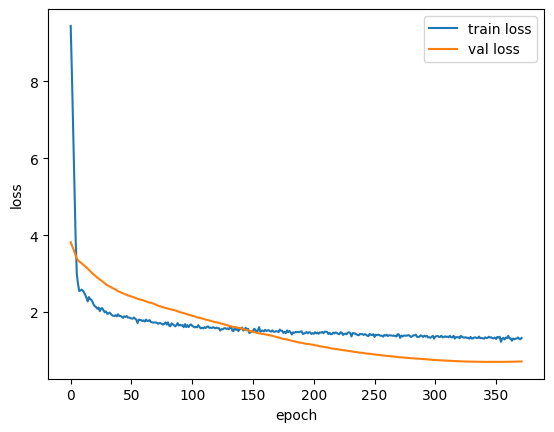

Best validation loss: 0.7058016061782837
epoch for best validation loss: 346


In [174]:
losses = pd.read_csv('losses.csv')
train_losses = losses['train_loss']
val_losses = losses['val_loss']

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
# set x-axis label
plt.xlabel('epoch')
# set y-axis label
plt.ylabel('loss')
plt.legend()
plt.show()

print("Best validation loss:", best_val_loss)
print("epoch for best validation loss:", np.argmin(val_losses))

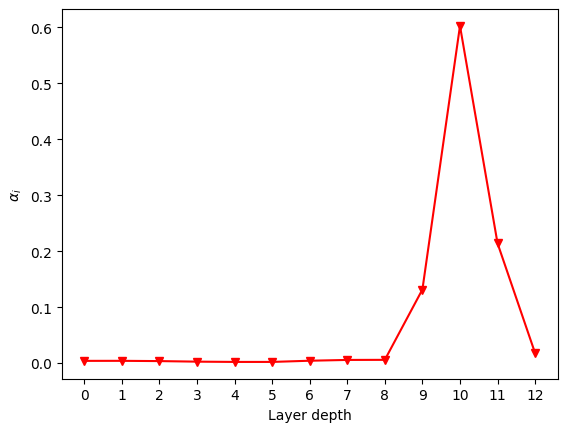

In [187]:
# plot the torch.nn.functional.softmax(dense_mos.weighted_average.weights, dim=0)
# aka the layer number and its importance
softmax_weights = torch.nn.functional.softmax(dense_mos.weighted_average.weights, dim=0).detach().cpu().numpy()

#save the weights to a csv
weights = pd.DataFrame({'softmax_weights': softmax_weights})
weights.to_csv('softmax_weights.csv', index=False)

plt.plot(softmax_weights, marker='v', linestyle='-', color='red', alpha=1, label='Softmax Weights')
plt.xlabel('Layer depth')
plt.xticks(range(13))
# y label is alpha character, the greek letter, with a subindice 
plt.ylabel(r'$\alpha_i$')
plt.show()

# Evaluation and Testing

In [181]:
# Create the testing DataLoader
test_csv_path = "/home/aleph/tesis/classifier/test.csv"
test_dataset = MOSDataset(test_csv_path, split='test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load the best model
best_model_path = "/home/aleph/tesis/classifier/DenseMOS_tests/final_model.pth"
dense_mos = DenseMOS(input_dim=768, hidden_dim=128, dropout_prob=0.6, num_layers=13)  # Ensure correct model initialization
dense_mos.to(device)  # Move the model to the device
dense_mos.load_state_dict(torch.load(best_model_path))  # Load the saved models
dense_mos.eval()  # Set model to evaluation mode

# Evaluate the model on the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # DataLoader for testing
test_loss = 0.0
outputs_list = []
targets_list = []
with torch.no_grad():  # No gradients needed during evaluation
    for inputs, targets in test_loader:
        inputs = inputs.to(device)  # Move inputs to the GPU
        targets = targets.to(device)  # Move targets to the GPU
        outputs = dense_mos(inputs)  # Forward pass
        outputs_list.append(outputs)
        targets_list.append(targets)
        loss = loss_fn(outputs, targets)  # Calculate loss
        test_loss += loss.item()  # Accumulate the loss

# Average test loss over all batches
avg_test_loss = test_loss / len(test_loader)
print("Test Loss:", avg_test_loss)  # Evaluate the model's performance on the test set

import numpy as np

# Convert targets and outputs to NumPy arrays
targets = np.squeeze(torch.cat(targets_list).cpu().numpy())
outputs = np.squeeze(torch.cat(outputs_list).cpu().numpy())


Test Loss: 1.455107295513153


In [177]:
# calculate pearson's correlation coefficient and targets_array, compute mae, mse, rmse and r2
# between the predicted MOS scores and the ground truth MOS scores, aka the targets and outputs

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

# Calculate Pearson's correlation coefficient
pearson_corr = pearsonr(targets, outputs)
print("Pearson's Correlation Coefficient:", pearson_corr[0])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(targets, outputs)
print("Mean Absolute Error (MAE):", mae)
rmse = mean_squared_error(targets, outputs, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)
r2 = r2_score(targets, outputs)
print("R^2 Score:", r2)



Pearson's Correlation Coefficient: 0.03537287364385683
Mean Absolute Error (MAE): 0.8567143
Root Mean Squared Error (RMSE): 1.1906047
R^2 Score: -0.9767362805970832


/home/aleph/tesis/.env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [182]:
# print target and outputs side by side
for i in range(200):
    print(f"Target: {targets[i]:.2f}, Output: {outputs[i]:.2f}")

Target: 1.50, Output: 0.85
Target: 1.00, Output: 0.88
Target: 1.00, Output: 0.78
Target: 1.00, Output: 1.03
Target: 2.00, Output: 0.66
Target: 2.00, Output: 0.81
Target: 1.00, Output: 0.90
Target: 1.00, Output: 0.83
Target: 2.00, Output: 0.90
Target: 3.00, Output: 0.92
Target: 3.00, Output: 0.84
Target: 1.00, Output: 0.90
Target: 1.00, Output: 1.05
Target: 1.00, Output: 0.93
Target: 3.00, Output: 1.20
Target: 1.00, Output: 0.96
Target: 1.00, Output: 1.04
Target: 1.00, Output: 1.05
Target: 1.50, Output: 0.80
Target: 1.50, Output: 0.73
Target: 1.00, Output: 0.98
Target: 1.50, Output: 0.97
Target: 1.00, Output: 0.74
Target: 3.00, Output: 1.22
Target: 2.00, Output: 1.16
Target: 1.00, Output: 0.95
Target: 1.00, Output: 0.68
Target: 1.00, Output: 0.90
Target: 1.00, Output: 0.96
Target: 3.00, Output: 0.97
Target: 2.00, Output: 0.87
Target: 3.00, Output: 0.99
Target: 2.00, Output: 0.79
Target: 2.00, Output: 0.87
Target: 1.00, Output: 0.71
Target: 2.00, Output: 0.54
Target: 2.00, Output: 1.10
T

### sanity check and experiments

In [84]:
def wav2vec_single_audio(path_to_audio, model_name):
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
    model = Wav2Vec2Model.from_pretrained(model_name)
    waveform, sample_rate = librosa.load(path_to_audio, sr=16000)
    inputs = feature_extractor(waveform, return_tensors="pt")
    with torch.no_grad():
        outputs= model(inputs.input_values)
    embeddings = outputs.last_hidden_state
    embeddings = embeddings.mean(dim=1)
    embeddings = embeddings.squeeze().detach().numpy()
                
    return embeddings

def compute_mos(embedding_path):
    best_model_path = "/home/aleph/tesis/classifier/DenseMOS_tests/best_model.pth"
    dense_mos = DenseMOS(input_dim=768, hidden_dim=128, dropout_prob=0.5, num_layers=12)  # Ensure correct model initialization
    dense_mos.to(device)  # Move the model to the device
    dense_mos.load_state_dict(torch.load(best_model_path))  # Load the saved models
    dense_mos.eval()  # Set model to evaluation mode

    #read the embeddings
    embedding = np.load(embedding_path)
    embedding = embedding[1:]
    new_audio_tensor = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    new_audio_tensor = new_audio_tensor.to(device)  # Move to the device

    # Make a prediction using the model
    with torch.no_grad():  # No gradients required for inference
        mos_score = dense_mos(new_audio_tensor)  # Forward pass to get the MOS score
    
    # Output the MOS score
    return mos_score.item()  # Get the scalar value from the tensor

best_model_path = "/home/aleph/tesis/classifier/best_model.pth"
embedding_path = "/home/aleph/tesis/classifier/embeddings/test/B9/VTLP_es-ES-ElviraNeural16.npy"


mos_score = compute_mos(embedding_path)
print("Predicted MOS score:", mos_score)

# compute for csv and save to new column
def compute_mos_for_csv(saved_model_path, path_to_csv, path_to_save_predictions):
    dense_mos = DenseMOS(input_dim=768, hidden_dim=128, dropout_prob=0.5, num_layers=12)  # Ensure model initialization
    dense_mos.load_state_dict(torch.load(best_model_path))  # Load the saved model
    dense_mos.eval()  # Set model to evaluation mode
    model_name = 'facebook/wav2vec2-base-960h'
    metadata_df = pd.read_csv(path_to_csv)
    metadata_df['predicted_mos'] = None
    for index, row in tqdm(metadata_df.iterrows()):
        audio_file = row['stimuli']
        new_audio_embeddings = wav2vec_single_audio(audio_file, model_name)

        # Convert to PyTorch tensor
        new_audio_tensor = torch.tensor(new_audio_embeddings, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

        # Make a prediction using the model
        with torch.no_grad():  # No gradients required for inference
            mos_score = dense_mos(new_audio_tensor)  # Forward pass to get the MOS score
        metadata_df.at[index, 'predicted_mos'] = mos_score.item()
    
        # append to file csv
        metadata_df.to_csv(path_to_save_predictions, index=False)

    return metadata_df

# path_to_csv = "/home/aleph/tesis/classifier/test_set_inference.csv"
# path_to_save_predictions = '/home/aleph/tesis/classifier/test_set_predictions.csv'

# predictions_df = compute_mos_for_csv(best_model_path, path_to_csv, path_to_save_predictions)
# print(predictions_df.head())


Predicted MOS score: 1.3363673686981201
